## Google Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 라이브러리 포함

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import VGG16


from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image

#ILSVRC 대회에서 성능 좋은 모델 제공
#https://keras.io/applications/
#keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#keras.applications.densenet.DenseNet169(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#keras.applications.densenet.DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

#keras.applications.resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#keras.applications.resnet.ResNet101(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#keras.applications.resnet.ResNet152(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#keras.applications.resnet_v2.ResNet50V2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#keras.applications.resnet_v2.ResNet101V2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#keras.applications.resnet_v2.ResNet152V2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

#conv_layers = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



## 폴더에 저장된 데이터셋을  ImageDataGenerator로 가져오기

In [3]:
#VGG16 입력형식으로  augmentation 처리 포함한 ImageDataGenerator 생성
data_aug_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      rescale=1./255
#      preprocessing_function=vgg16.preprocess_input
)
#VGG16 입력형식으로  augmentation 처리 없는 ImageDataGenerator 생성
data_no_aug_generator = ImageDataGenerator(
      rescale=1./255
#      preprocessing_function=vgg16.preprocess_input
)

##train폴더에서 데이터를 읽어서  train_data_generator 생성
train_img_path = '/content/drive/My Drive/Deep learning/data/Face/train/'
train_data_generator = data_aug_generator.flow_from_directory(
      train_img_path,
      target_size=(224,224),
      batch_size=30,
      class_mode='sparse'
)
##test 폴더에서 데이터를 읽어서  train_data_generator 생성
test_img_path = '/content/drive/My Drive/Deep learning/data/Face/test/'
test_data_generator = data_no_aug_generator.flow_from_directory(
      test_img_path ,
      target_size=(224,224),
      class_mode='sparse'
)

Found 413 images belonging to 18 classes.
Found 126 images belonging to 18 classes.


## Visualize training images

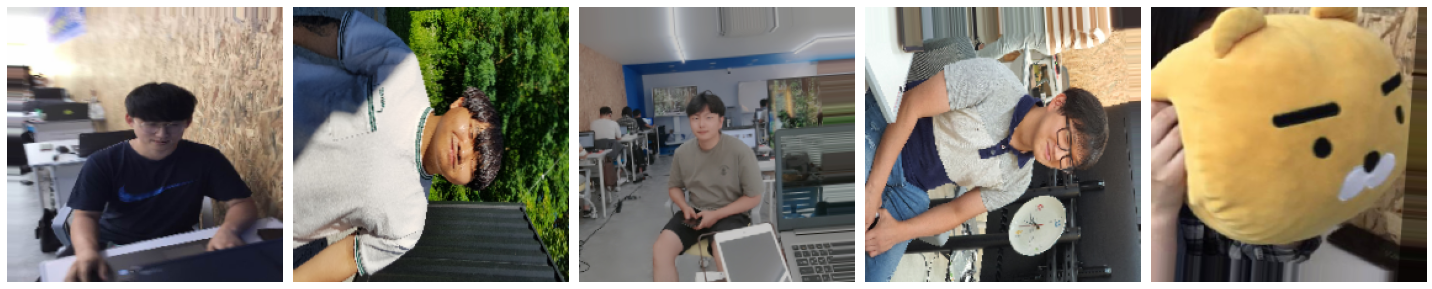

In [4]:
#train_data_gen에서 batch size만큼 학습이미지만 추출하여 확인

sample_training_images, _ = next(train_data_generator)

# 이미지 plot (1줄에 5개 출력)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])

## Create the model

- (1)convolution blocks (ImageNET을 사전 학습한 VGG16모델)
- (2)classifier (fully connected layer)
- Dense(1024)
- Dropout(0.5)
- Dense(2)

In [5]:
# include_top = False : convolution block 고정, classifier만 학습
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers.trainable = False : conv_layers 가중치를 변경하지 않는다.  (layer.trainable = False) : 훈련 중 지정된 레이어의 가중치가 수정안됨
conv_layers.trainable = False

model = Sequential([
            conv_layers,
            Flatten(),
            Dense(1024, activation='relu'),
            Dropout(0.5),
            Dense(18, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Model summary

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                18450     
Total params: 40,424,274
Trainable params: 25,709,586
Non-trainable params: 14,714,688
_________________________________________________________________


## Train the model

In [7]:
epochs=10

history = model.fit_generator(
      train_data_generator,
      validation_data=test_data_generator,
      validation_steps=5,
      steps_per_epoch=train_data_generator.samples/30,
      epochs= epochs
)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
14/13 [==============================] - 49s 4s/step - loss: 8.3031 - accuracy: 0.1695 - val_loss: 1.5248 - val_accuracy: 0.5635
Epoch 2/10
14/13 [==============================] - 47s 3s/step - loss: 1.8629 - accuracy: 0.5521 - val_loss: 0.9912 - val_accuracy: 0.6429
Epoch 3/10
14/13 [==============================] - 49s 3s/step - loss: 0.9694 - accuracy: 0.7022 - val_loss: 0.7013 - val_accuracy: 0.7857
Epoch 4/10
14/13 [==============================] - 48s 3s/step - loss: 0.6750 - accuracy: 0.7966 - val_loss: 0.6544 - val_accuracy: 0.7857
Epoch 5/10
14/13 [==============================] - 48s 3s/step - loss: 0.6048 - accuracy: 0.8136 - val_loss: 0.5867 - val_accuracy: 0.8095
Epoch 6/10
14/13 [==============================] - 46s 3s/step - loss: 0.5507 - accuracy: 0.8378 - val_loss: 0.6308 - val_accuracy: 0.7540
Epoch 7/10
14/13 [==============================] - 48s 3s/step - loss: 0.3793 - acc

## Visualize training results

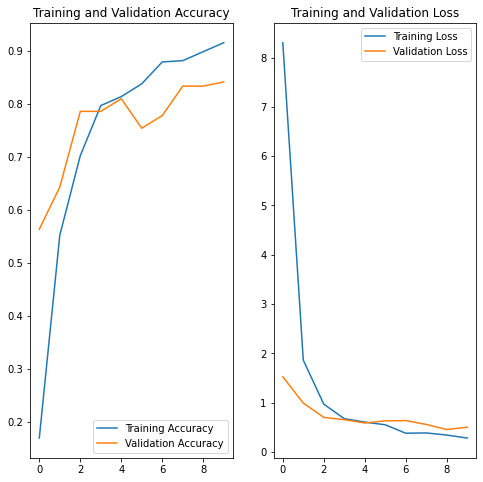

In [8]:
 epochs = 10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict new test image

In [9]:
y_ = model.predict_generator(
      test_data_generator,
      steps=test_data_generator.samples/30
)

custom_labels = list(test_data_generator.class_indices.keys())
predicted = np.argmax(y_, axis=1)
print(predicted.shape)
print(predicted[0], custom_labels[predicted[0]])
print(predicted[1], custom_labels[predicted[1]])

Instructions for updating:
Please use Model.predict, which supports generators.
(126,)
5 JangHB
3 Inseo


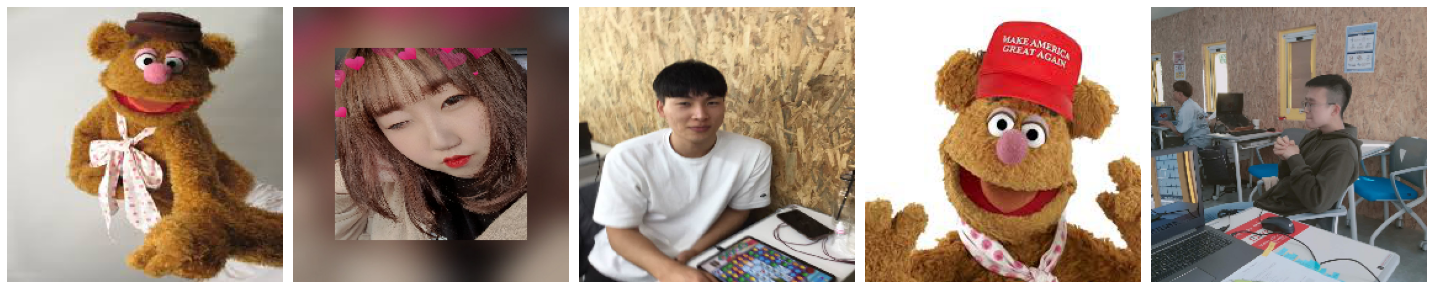

In [10]:
#test_data_gen에서 batch size만큼 이미지만 추출하여 확인

test_images, _ = next(test_data_generator)

# 이미지 plot (1줄에 5개 출력)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(test_images[:5])

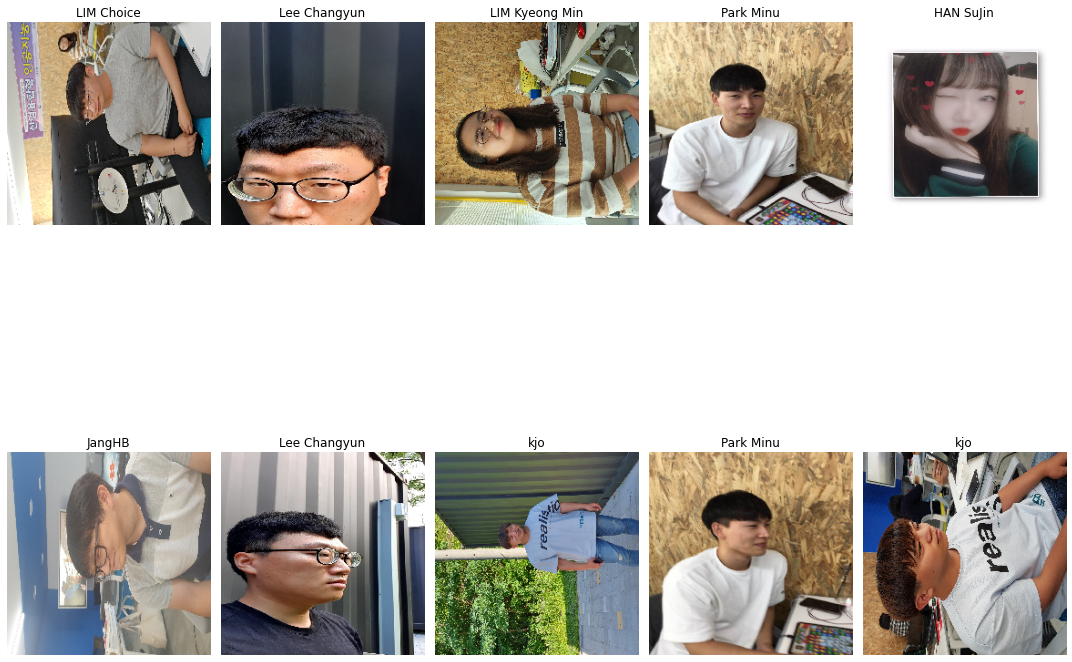

In [34]:
#test_data_gen에서 batch size만큼 이미지만 추출하여 확인

test_image, _ = next(test_data_generator)

# 이미지 plot (1줄에 5개 출력)
def plotImages(images_arr):
    custom_labels = list(test_data_generator.class_indices.keys())
    pre = model.predict_generator(images_arr)
    predicted = np.argmax(pre, axis=1)
    plt.figure(figsize=(15,15))
    for i in range(10):
        pre_name = custom_labels[predicted[i]]
        plt.subplot(2,5,i+1)
        plt.imshow(images_arr[i])
        plt.axis('off')
        plt.title(pre_name)
    plt.tight_layout()
    plt.show()

plotImages(test_image)